In [1]:
import pandas as pd
from partial_ranker import Graph


### The Class

In [18]:
%%writefile ../partial_ranker_dfg.py
# Partial Ranker
#
# Copyright (C) 2019-2024, Aravind Sankaran
# IRTG-2379: Modern Inverse Problems, RWTH Aachen University, Germany
# HPAC, Umeå University, Sweden
#
# This program is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# any later version.
#
# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.
#
# You should have received a copy of the GNU General Public License
# along with this program.  If not, see <http://www.gnu.org/licenses/>.
#
# Contributors:
# - Aravind Sankaran

import pandas as pd
from .graph import Graph

class PartialRankerDFG:
    """DFG based parial ranking methodology (Methodology 1 in the paper).
    
    Input:
        comparison_matrix (dict[str, dict[str, int]]): (Input) Comparison matrix from the Comparator.
        
    Attributes:
        dependencies (dict[str,list[str]]): If obj_i is better than obj_j, then the value of obj_j in the dictionary is a list containing obj_i. 
        e.g.; in the dict {'obj1': ['obj2', 'obj3], 'obj2': ['obj4'], ...}, obj2 and obj3 are better than obj1, obj4 is better than obj2, etc.
    """
    def __init__(self,comparer):
        self.objs = list(comparer.C.keys())
        self._obj_rank = {}
        self._rank_objs = {}
        cm = pd.DataFrame(comparer.C)
        self.dependencies = dict(cm.apply(lambda row: row[row == 0].index.tolist(), axis=1))
    
    def compute_ranks(self):
        """Computes the partial ranks of the objects according to Methodology 1. 
        The ranks of an object corresponds to the depth of the object in the dependency graph.
        """
        self._obj_rank = {}
        self._rank_objs = {}
        for obj in self.objs:
            d = self._get_depth(obj)
            self._rank_objs[d] = self._rank_objs.get(d,[]) + [obj]
    
    def _get_depth(self,obj):
        if obj in self._obj_rank:
            return self._obj_rank[obj]
        else:
            v = self.dependencies[obj]
            if not v:
                self._obj_rank[obj] = 0
            else:
                self._obj_rank[obj] = max([self._get_depth(i) for i in v]) + 1
            return self._obj_rank[obj]
        
    def get_ranks(self):
        """Returns the partial ranks of the objects.
        
        Returns:
            dict[int,List[str]]: Dictionary with list of objects at each rank.
        """
        return self._rank_objs
    
    def get_rank_obj(self,obj):
        """Returns the partial rank of the object.
        
        Args:
            obj (str): Object name.
        
        Returns:
            int: Partial rank of the object.
        """
        return self._obj_rank[obj]
    
    def get_dfg(self):
        """Visualizes the dependency graph.
        """
        g = Graph(self.dependencies, self.get_ranks()) 
        return g
    
        

Overwriting ../partial_ranker_dfg.py


### Requirements

In [3]:
import numpy as np
from partial_ranker.measurements_simulator import MeasurementsSimulator
from partial_ranker.measurements_visualizer import MeasurementsVisualizer
from partial_ranker import QuantileComparer

1) Prepare sample measurements

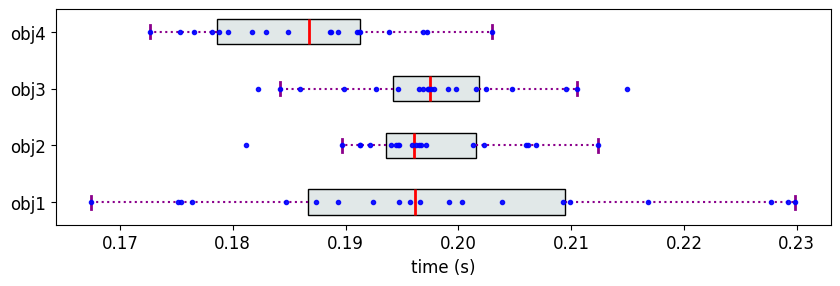

In [4]:
obj_params = {}
obj_params['obj1']  = [0.2,0.02] # [mean, std]
obj_params['obj2']  = [0.2,0.01]
obj_params['obj3']  = [0.2,0.01]
obj_params['obj4']  = [0.19,0.01]
ms = MeasurementsSimulator(obj_params,seed=129)
reps = 20
ms.measure(reps=reps)
measurements = ms.get_measurements()
h0 = list(obj_params.keys())
mv = MeasurementsVisualizer(measurements, h0)
fig = mv.show_measurements_boxplots(scale=0.7)

2) Compare

In [5]:
comparer = QuantileComparer(measurements)
comparer.compute_quantiles(q_max=75, q_min=25,outliers=False)
comparer.compare()
comparer.C

{'obj1': {'obj1': -1, 'obj2': 1, 'obj3': 1, 'obj4': 1},
 'obj2': {'obj1': 1, 'obj2': -1, 'obj3': 1, 'obj4': 2},
 'obj3': {'obj1': 1, 'obj2': 1, 'obj3': -1, 'obj4': 2},
 'obj4': {'obj1': 1, 'obj2': 0, 'obj3': 0, 'obj4': -1}}

### Usage

In [7]:
pr_dfg = PartialRankerDFG(comparer)
pr_dfg.dependencies

{'obj1': [], 'obj2': ['obj4'], 'obj3': ['obj4'], 'obj4': []}

In [8]:
pr_dfg.compute_ranks()
pr_dfg._obj_rank

{'obj1': 0, 'obj4': 0, 'obj2': 1, 'obj3': 1}

In [9]:
pr_dfg.get_ranks()

{0: ['obj1', 'obj4'], 1: ['obj2', 'obj3']}

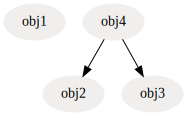

In [10]:
pr_dfg.get_dfg().visualize()

### Scaling experiment

In [11]:
def create_measurements(n_objs, n_reps, seed=129):
    obj_params = {}
    for i in range(n_objs):
        obj_params[f'obj{i}'] = [np.random.uniform(0,1), np.random.uniform(0,0.1)]
    ms = MeasurementsSimulator(obj_params,seed=seed)
    ms.measure(reps=n_reps)
    return ms.get_measurements()

In [12]:
measurements = create_measurements(1000, 5)

In [15]:
#%%timeit -n 1 -r 3
cm = QuantileComparer(measurements)
cm.compute_quantiles(75, 25,False)
cm.compare()

In [16]:
pr_dfg = PartialRankerDFG(cm)

In [17]:
%%timeit -n 1 -r 3
pr_dfg.compute_ranks()

61.8 ms ± 1.32 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
